In [1]:
import numpy as np
import xarray as xr

import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe

# Open SOS slow data

In [2]:
sos_df = pd.read_parquet("../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet")
sos_df_localtime = utils.modify_df_timezone( sos_df, 'UTC', 'US/Mountain')

## Plot wind directions for case studies

In [ ]:
def wind_chart(data):
    return alt.Chart(data).mark_line().encode(        
        alt.X('time:T'),
        alt.Y('value:Q'),
        alt.Color('height:O').scale(scheme='rainbow')
    ).properties(height=150)
def vertical_lines_chart(data):
    return alt.Chart(
        data
    ).mark_rule(color='red', strokeDash=[4, 2]).encode(
        alt.X('time:T')
    )


sos_dir_df = sos_df_localtime[sos_df_localtime.variable.isin([
        'dir_3m_c', 'dir_10m_c', 'dir_20m_c'
    ])].set_index('time')

(
    (wind_chart(sos_dir_df.loc['20230409'].reset_index())   + vertical_lines_chart(pd.DataFrame({'time': ['2023-04-09T15:00:00', '2023-04-09T18:00:00']}))) 
    | (wind_chart(sos_dir_df.loc['20230418'].reset_index()) + vertical_lines_chart(pd.DataFrame({'time': ['2023-04-18T15:00:00', '2023-04-18T18:00:00']}))) 
    | (wind_chart(sos_dir_df.loc['20221221'].reset_index()) + vertical_lines_chart(pd.DataFrame({'time': ['2022-12-21T15:00:00', '2022-12-21T18:00:00']}))) 
    | (wind_chart(sos_dir_df.loc['20230304'].reset_index()) + vertical_lines_chart(pd.DataFrame({'time': ['2023-03-04T15:00:00', '2023-03-04T18:00:00']})))
)

In [ ]:
sos_dir_df.sort_index().loc['20230418 1900': '20230418 2200'].query("variable == 'dir_3m_c'").value.mean()

# Open SOS fast data

In [ ]:
apr18_df = fast_data_files_to_dataframe([
    # '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230418_21.nc',
    # '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230418_22.nc',
    # '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230418_23.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230419_01.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230419_02.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230419_03.nc',
],  rotation='double')

apr18_df = utils.modify_df_timezone(apr18_df, pytz.UTC, "US/Mountain")

In [ ]:
src = apr18_df.set_index('time')[['u_10m_c', 'w_10m_c']]
src_fluc = src - src.groupby(pd.Grouper(freq='30min')).transform('mean')
plt.hist2d(src_fluc.u_10m_c, src_fluc.w_10m_c, bins=500, cmap='Reds')
plt.axhline(0)
plt.axvline(0)
plt.colorbar()
plt.xlim(-2,2); plt.ylim(-2,2)
plt.show()

# Spectra across two case study days - Apr 18 and Dec 21

## Apr 18

### u'w' cospectra - all ECs

In [ ]:
apr18_u_w_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_c', 'w_3m_c', shift = 2000, parallelism=8)
apr18_u_w_3m_d_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_d', 'w_3m_d', shift = 2000, parallelism=8)
apr18_u_w_3m_ue_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_ue', 'w_3m_ue', shift = 2000, parallelism=8)
apr18_u_w_3m_uw_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_uw', 'w_3m_uw', shift = 2000, parallelism=8)

apr18_u_w_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_c', 'w_10m_c', shift = 2000, parallelism=8)
apr18_u_w_10m_d_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_d', 'w_10m_d', shift = 2000, parallelism=8)
apr18_u_w_10m_ue_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_ue', 'w_10m_ue', shift = 2000, parallelism=8)
apr18_u_w_10m_uw_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_uw', 'w_10m_uw', shift = 2000, parallelism=8)

apr18_u_w_5m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_5m_c', 'w_5m_c', shift = 2000, parallelism=8)
apr18_u_w_15m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_15m_c', 'w_15m_c', shift = 2000, parallelism=8)
apr18_u_w_20m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_20m_c', 'w_20m_c', shift = 2000, parallelism=8)

In [ ]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log').title('tau (s)'),
)
def mrd_plot(data, title=''):
    return alt.layer(
        base.mark_errorband(extent='iqr').encode(alt.Y('Co:Q')),
        base.mark_line().encode(alt.Y('mean(Co):Q')),
        data=data
    ).properties(width=200, height=200, title=title)

In [ ]:
(
    (
        mrd_plot(apr18_u_w_3m_c_mrd_df, "u'w', 3m-C") | mrd_plot(apr18_u_w_3m_d_mrd_df, "u'w', 3m-D") 
        | mrd_plot(apr18_u_w_3m_ue_mrd_df, "u'w', 3m-UE") | mrd_plot(apr18_u_w_3m_uw_mrd_df, "u'w', 3m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(apr18_u_w_10m_c_mrd_df, "u'w', 10m-C") | mrd_plot(apr18_u_w_10m_d_mrd_df, "u'w', 10m-D") 
        | mrd_plot(apr18_u_w_10m_ue_mrd_df, "u'w', 10m-UE") | mrd_plot(apr18_u_w_10m_uw_mrd_df, "u'w', 10m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(apr18_u_w_5m_c_mrd_df, "u'w', 5m-C") |  mrd_plot(apr18_u_w_15m_c_mrd_df, "u'w', 15m-C") |  mrd_plot(apr18_u_w_20m_c_mrd_df, "u'w', 20m-C")
    ).resolve_scale(y='shared')
).resolve_scale(y='shared')

### Isotropic stress cospectra - tower c 3 and 10m

In [ ]:
apr18_u_u_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_c', 'u_3m_c', shift = 2000, parallelism=8)
apr18_v_v_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'v_3m_c', 'v_3m_c', shift = 2000, parallelism=8)
apr18_w_w_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'w_3m_c', 'w_3m_c', shift = 2000, parallelism=8)

apr18_u_u_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_c', 'u_10m_c', shift = 2000, parallelism=8)
apr18_v_v_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'v_10m_c', 'v_10m_c', shift = 2000, parallelism=8)
apr18_w_w_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'w_10m_c', 'w_10m_c', shift = 2000, parallelism=8)

In [ ]:
((
    mrd_plot(apr18_u_u_3m_c_mrd_df, "u'u', 3m-C") | mrd_plot(apr18_v_v_3m_c_mrd_df, "v'v', 3m-C") 
).resolve_scale(y='shared') & (
    mrd_plot(apr18_u_u_10m_c_mrd_df, "u'u', 10-C") | mrd_plot(apr18_v_v_10m_c_mrd_df, "v'v', 3m-C")
).resolve_scale(y='shared')).resolve_scale(y='shared') | (
    mrd_plot(apr18_w_w_3m_c_mrd_df, "w'w', 3m-C") & mrd_plot(apr18_w_w_10m_c_mrd_df, "w'w', 10m-C")
).resolve_scale(y='shared')

## Dec 21

In [ ]:
dec21_df = fast_data_files_to_dataframe([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20221221_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20221221_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20221221_23.nc',
],  rotation='double')
dec21_df = utils.modify_df_timezone(dec21_df, pytz.UTC, "US/Mountain")

### u'w' cospectra - all ECs

In [ ]:
dec21_u_w_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'w_3m_c', shift = 2000, parallelism=8)
dec21_u_w_3m_d_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_d', 'w_3m_d', shift = 2000, parallelism=8)
dec21_u_w_3m_ue_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_ue', 'w_3m_ue', shift = 2000, parallelism=8)
dec21_u_w_3m_uw_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_uw', 'w_3m_uw', shift = 2000, parallelism=8)

dec21_u_w_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_c', 'w_10m_c', shift = 2000, parallelism=8)
dec21_u_w_10m_d_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_d', 'w_10m_d', shift = 2000, parallelism=8)
dec21_u_w_10m_ue_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_ue', 'w_10m_ue', shift = 2000, parallelism=8)
dec21_u_w_10m_uw_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_uw', 'w_10m_uw', shift = 2000, parallelism=8)

dec21_u_w_5m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_5m_c', 'w_5m_c', shift = 2000, parallelism=8)
dec21_u_w_15m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_15m_c', 'w_15m_c', shift = 2000, parallelism=8)
dec21_u_w_20m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_20m_c', 'w_20m_c', shift = 2000, parallelism=8)

In [ ]:
def mrd_plot(data, title='', color=None):
    base = alt.Chart().encode(
        alt.X('tau:Q').scale(type='log').title('tau (s)'),
    )
    if color:
        band = base.mark_errorband(extent='iqr', color=color).encode(alt.Y('Co:Q'))
        line = base.mark_line(color=color).encode(alt.Y('mean(Co):Q'))
    else:
        band = base.mark_errorband(extent='iqr').encode(alt.Y('Co:Q'))
        line = base.mark_line().encode(alt.Y('mean(Co):Q'))
    return alt.layer(
        band, line, data=data
    ).properties(width=200, height=200, title=title)

In [ ]:
(
    (
        mrd_plot(dec21_u_w_3m_c_mrd_df, "u'w', 3m-C") | mrd_plot(dec21_u_w_3m_d_mrd_df, "u'w', 3m-D") 
        | mrd_plot(dec21_u_w_3m_ue_mrd_df, "u'w', 3m-UE") | mrd_plot(dec21_u_w_3m_uw_mrd_df, "u'w', 3m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(dec21_u_w_10m_c_mrd_df, "u'w', 10m-C") | mrd_plot(dec21_u_w_10m_d_mrd_df, "u'w', 10m-D") 
        | mrd_plot(dec21_u_w_10m_ue_mrd_df, "u'w', 10m-UE") | mrd_plot(dec21_u_w_10m_uw_mrd_df, "u'w', 10m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(dec21_u_w_5m_c_mrd_df, "u'w', 5m-C") |  mrd_plot(dec21_u_w_15m_c_mrd_df, "u'w', 15m-C") |  mrd_plot(dec21_u_w_20m_c_mrd_df, "u'w', 20m-C")
    ).resolve_scale(y='shared')
).resolve_scale(y='shared')

In [ ]:
(mrd_plot(dec21_u_w_3m_c_mrd_df, "u'w', 3m-C") + mrd_plot(apr18_u_w_3m_c_mrd_df, "u'w', 3m-C", color='#ff7f0e') + mrd_plot(apr18_u_w_3m_d_mrd_df, "u'w', 3m-C", color='#ff7f0e') + mrd_plot(apr18_u_w_3m_ue_mrd_df, "u'w', 3m-C", color='#ff7f0e') + mrd_plot(apr18_u_w_3m_uw_mrd_df, "u'w', 3m-C", color='#ff7f0e')) |\
(mrd_plot(dec21_u_w_10m_c_mrd_df, "u'w', 10m-C") + mrd_plot(apr18_u_w_10m_c_mrd_df, "u'w', 10m-C", color='#ff7f0e')) |\
(mrd_plot(dec21_u_w_5m_c_mrd_df, "u'w', 5m-C") + mrd_plot(apr18_u_w_5m_c_mrd_df, "u'w', 5m-C", color='#ff7f0e'))

### Isotropic stress cospectra - tower c 3 and 10m

In [ ]:
dec21_u_u_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'u_3m_c', shift = 2000, parallelism=8)
dec21_v_v_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'v_3m_c', 'v_3m_c', shift = 2000, parallelism=8)
dec21_w_w_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'w_3m_c', 'w_3m_c', shift = 2000, parallelism=8)

dec21_u_u_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_c', 'u_10m_c', shift = 2000, parallelism=8)
dec21_v_v_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'v_10m_c', 'v_10m_c', shift = 2000, parallelism=8)
dec21_w_w_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'w_10m_c', 'w_10m_c', shift = 2000, parallelism=8)

In [ ]:
((
    mrd_plot(dec21_u_u_3m_c_mrd_df, "u'u', 3m-C") | mrd_plot(dec21_v_v_3m_c_mrd_df, "v'v', 3m-C") 
).resolve_scale(y='shared') & (
    mrd_plot(dec21_u_u_10m_c_mrd_df, "u'u', 10-C") | mrd_plot(dec21_v_v_10m_c_mrd_df, "v'v', 3m-C")
).resolve_scale(y='shared')).resolve_scale(y='shared') | (
    mrd_plot(dec21_w_w_3m_c_mrd_df, "w'w', 3m-C") & mrd_plot(dec21_w_w_10m_c_mrd_df, "w'w', 10m-C")
).resolve_scale(y='shared')

# Spectra across two months of data

Open up all the nomrd files. Calculate a "median time" for joining with synoptic wind measurements

In [ ]:
nomrd_df = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/mrd/NOmrds/")
nomrd_df['median_time'] = nomrd_df.start_time + 0.5*(nomrd_df.end_time - nomrd_df.start_time)
nomrd_df['median_time_rounded'] = nomrd_df.median_time.dt.round('30min')
nomrd_df

Remove the Dec 21 MRD

In [ ]:
nomrd_df = nomrd_df[nomrd_df.start_time.dt.month != 12]

In [ ]:
nomrd_df.start_time.dt.hour.min(), nomrd_df.start_time.dt.hour.max()

Use doppler lidar data to identify along-valley/cross-valley synoptic flows

In [ ]:
cross_valley_wind_times = pd.read_csv('cross_valley_wind_times.csv').drop(columns='Unnamed: 0').rename(columns={'0':'time'}).set_index('time').assign(
    wind_dir='cross-valley'
)
cross_valley_wind_times.index = pd.to_datetime(cross_valley_wind_times.index)

along_valley_wind_times = pd.read_csv('along_valley_wind_times.csv').drop(columns='Unnamed: 0').rename(columns={'0':'time'}).set_index('time').assign(
    wind_dir='along-valley'
)
along_valley_wind_times.index = pd.to_datetime(along_valley_wind_times.index)

winds_ge10_times =      pd.read_csv('winds_ge10_times.csv').drop(columns='Unnamed: 0').set_index('time').assign(wind_speed='> 10')
winds_ge10_times.index = pd.to_datetime(winds_ge10_times.index)
winds_le10_times =      pd.read_csv('winds_le10_times.csv').drop(columns='Unnamed: 0').set_index('time').assign(wind_speed='<= 10')
winds_le10_times.index = pd.to_datetime(winds_le10_times.index)

Join the datasets

In [ ]:
nomrd_df_synopticwinds = pd.concat([
    nomrd_df.set_index('median_time_rounded').join(cross_valley_wind_times, how='inner'),
    nomrd_df.set_index('median_time_rounded').join(along_valley_wind_times, how='inner')
])
nomrd_df_synopticwinds = nomrd_df_synopticwinds.join(pd.concat([ winds_le10_times, winds_ge10_times]), how='inner')

In [ ]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Color('wind_dir:N'),
).properties(width=200, height=200, title = "u'w', 3m-c")

def layer_plot(data, title=''):
    return alt.layer(
        base.encode(alt.Y('Co:Q')).mark_errorband(extent='iqr'),
        base.encode(alt.Y('mean(Co):Q')).mark_line(),
        data = data
    ).facet(alt.Row('wind_speed')).properties(title=title)

In [ ]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]
src['date'] = src.start_time.dt.date.astype('str')
alt.Chart(
    src.query("loc == '3m_c'")
).mark_line(strokeWidth=1, point={'size': 10}).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Detail('date'),
    alt.Color('wind_dir:N'),
    alt.Facet('wind_speed'),
    tooltip = 'date'
).properties(width=200, height=200)

In [ ]:
4/18, 3/8, 4/2, 3/6

In [ ]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]

(
    layer_plot(src.query("loc == '3m_c'"), title="u'w' 3m_c")
    &\
    layer_plot(src.query("loc == '5m_c'"), title="u'w' 5m_c")
    &\
    layer_plot(src.query("loc == '10m_c'"), title="u'w' 10m_c")
    &\
    layer_plot(src.query("loc == '15m_c'"), title="u'w' 15m_c")
    &\
    layer_plot(src.query("loc == '20m_c'"), title="u'w' 20m_c")

) 

In [ ]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]

(
    layer_plot(src.query("loc == '3m_c'"), title="u'w' 3m_c") | layer_plot(src.query("loc == '3m_d'"), title="u'w' 3m_d") | layer_plot(src.query("loc == '3m_ue'"), title="u'w' 3m_ue") | layer_plot(src.query("loc == '3m_uw'"), title="u'w' 3m_uw")
) &\
layer_plot(src.query("loc == '5m_c'"), title="u'w' 5m_c") &\
(
    layer_plot(src.query("loc == '10m_c'"), title="u'w' 10m_c") | layer_plot(src.query("loc == '10m_d'"), title="u'w' 10m_d") | layer_plot(src.query("loc == '10m_ue'"), title="u'w' 10m_ue") | layer_plot(src.query("loc == '10m_uw'"), title="u'w' 10m_uw")
)  &\
layer_plot(src.query("loc == '15m_c'"), title="u'w' 15m_c") &\
layer_plot(src.query("loc == '20m_c'"), title="u'w' 20m_c")

In [ ]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]
(
    layer_plot(src.query("loc == '3m_c'"), title="u'w' 3m_c") |\
    layer_plot(src.query("loc == '5m_c'"), title="u'w' 5m_c") |\
    layer_plot(src.query("loc == '10m_c'"), title="u'w' 10m_c")
) & (
    layer_plot(src.query("loc == '15m_c'"), title="u'w' 15m_c") |\
    layer_plot(src.query("loc == '20m_c'"), title="u'w' 20m_c")
)

In [ ]:
src = nomrd_df_synopticwinds.query("covariance == 'v_w_'")
src = src[src.index.hour.isin([15, 16, 17])]

(
    layer_plot(src.query("loc == '3m_c'")) | layer_plot(src.query("loc == '3m_d'")) | layer_plot(src.query("loc == '3m_ue'")) | layer_plot(src.query("loc == '3m_uw'"))
) &\
layer_plot(src.query("loc == '5m_c'")) &\
(
    layer_plot(src.query("loc == '10m_c'")) | layer_plot(src.query("loc == '10m_d'")) | layer_plot(src.query("loc == '10m_ue'")) | layer_plot(src.query("loc == '10m_uw'"))
)  &\
layer_plot(src.query("loc == '15m_c'")) &\
layer_plot(src.query("loc == '20m_c'"))

# Do the calculations on the fly

see scipt: analysis/paper2/spectral_analysis_kps_calculate_seasonal_spectra.py

### Open the data

In [3]:
daily_mrds_df = pd.read_parquet('mrds/uw/')
daily_mrds_uv_df = pd.read_parquet('mrds/uv/')
daily_mrds_vw_df = pd.read_parquet('mrds/vw/')

### Classify each day into the synoptic wind categories

In [4]:
DATA_DIR = "/Users/elischwat/Development/data/sublimationofsnow/"

In [5]:
windprof_ds = xr.open_mfdataset(sorted(glob.glob(os.path.join(DATA_DIR, 'gucdlprofwind4newsM1.c1', "*.nc"))))

In [6]:
windprof_df = windprof_ds[['wind_speed', 'wind_direction']].to_dataframe().reset_index()

In [7]:
synoptic_winds_df = windprof_df.query("height >= 1000").query("height <= 1500")
synoptic_winds_df = synoptic_winds_df.set_index('time').resample('24h').apply({
    'wind_speed': 'mean',
    'wind_direction': 'median'
})

In [8]:
along_valley_wind_days = synoptic_winds_df[
    (synoptic_winds_df.wind_direction > 300)
    | (synoptic_winds_df.wind_direction < 5 )
].index.values
cross_valley_wind_days = synoptic_winds_df[
    (synoptic_winds_df.wind_direction > 185)
    & (synoptic_winds_df.wind_direction < 265 )
].index.values

slow_wind_days = synoptic_winds_df[synoptic_winds_df.wind_speed <= 10].index.values
fast_wind_days = synoptic_winds_df[synoptic_winds_df.wind_speed > 10].index.values

In [9]:
fast_along_valley_wind_days = pd.Series(list(set(fast_wind_days).intersection(set(along_valley_wind_days)))).dt.date
fast_cross_valley_wind_days = pd.Series(list(set(fast_wind_days).intersection(set(cross_valley_wind_days)))).dt.date
slow_along_valley_wind_days = pd.Series(list(set(slow_wind_days).intersection(set(along_valley_wind_days)))).dt.date
slow_cross_valley_wind_days = pd.Series(list(set(slow_wind_days).intersection(set(cross_valley_wind_days)))).dt.date

In [10]:
print(len(fast_along_valley_wind_days))
print(len(fast_cross_valley_wind_days))
print(len(slow_along_valley_wind_days))
print(len(slow_cross_valley_wind_days))

22
44
24
36


In [11]:
daily_mrds_df['date'] = daily_mrds_df['start_time'].dt.date
daily_mrds_df['start_time_nodate'] = daily_mrds_df['start_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_df['end_time_nodate'] = daily_mrds_df['end_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_df['midpoint_time_nodate'] = daily_mrds_df['start_time_nodate'] + (daily_mrds_df['end_time_nodate'] - daily_mrds_df['start_time_nodate']) / 2

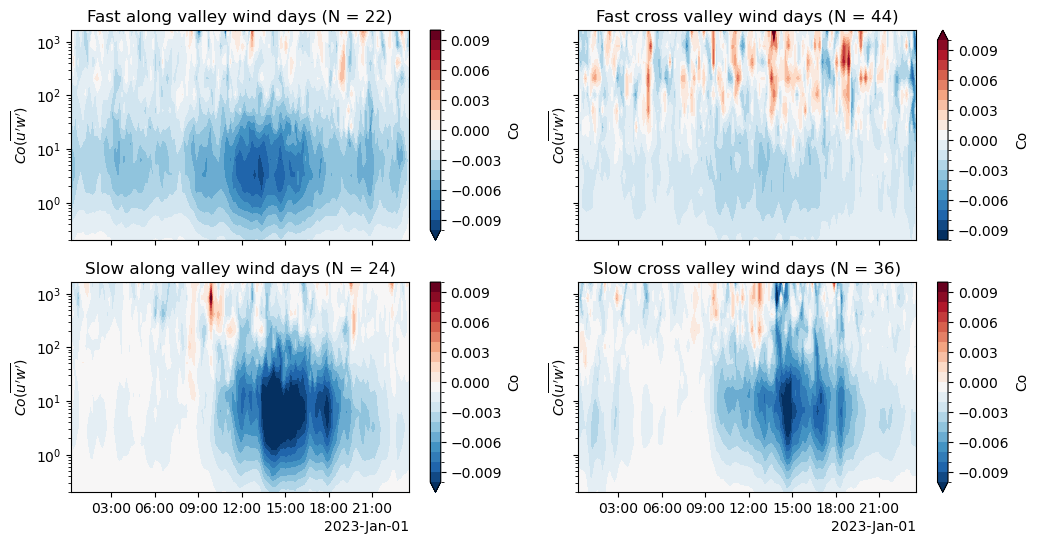

In [12]:
fig, axes = plt.subplots(2,2, figsize=(12,6), sharex=True, sharey=True)
LIM = 0.01
# fast_along_valley_wind_days
ds_daily_avg = daily_mrds_df[daily_mrds_df.date.isin(
    fast_along_valley_wind_days
)].groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau']
)[['Co']].mean().reset_index().set_index(['midpoint_time_nodate', 'tau']).to_xarray()
ds_daily_avg['Co'].plot.contourf(x='midpoint_time_nodate', y='tau', cmap='RdBu_r', levels=21, vmin=-LIM, vmax=LIM, ax=axes[0,0])
axes[0,0].set_title(f'Fast along valley wind days (N = {len(fast_along_valley_wind_days)})')

# fast_cross_valley_wind_days
ds_daily_avg = daily_mrds_df[daily_mrds_df.date.isin(
    fast_cross_valley_wind_days
)].groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau']
)[['Co']].mean().reset_index().set_index(['midpoint_time_nodate', 'tau']).to_xarray()
ds_daily_avg['Co'].plot.contourf(x='midpoint_time_nodate', y='tau', cmap='RdBu_r', levels=21, vmin=-LIM, vmax=LIM, ax=axes[0,1])
axes[0,1].set_title(f'Fast cross valley wind days (N = {len(fast_cross_valley_wind_days)})')

# slow_along_valley_wind_days
ds_daily_avg = daily_mrds_df[daily_mrds_df.date.isin(
    slow_along_valley_wind_days
)].groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau']
)[['Co']].mean().reset_index().set_index(['midpoint_time_nodate', 'tau']).to_xarray()
ds_daily_avg['Co'].plot.contourf(x='midpoint_time_nodate', y='tau', cmap='RdBu_r', levels=21, vmin=-LIM, vmax=LIM, ax=axes[1,0])
axes[1,0].set_title(f'Slow along valley wind days (N = {len(slow_along_valley_wind_days)})')

# slow_cross_valley_wind_days
ds_daily_avg = daily_mrds_df[daily_mrds_df.date.isin(
    slow_cross_valley_wind_days
)].groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau']
)[['Co']].mean().reset_index().set_index(['midpoint_time_nodate', 'tau']).to_xarray()
ds_daily_avg['Co'].plot.contourf(x='midpoint_time_nodate', y='tau', cmap='RdBu_r', levels=21, vmin=-LIM, vmax=LIM, ax=axes[1,1])
axes[1,1].set_title(f'Slow cross valley wind days (N = {len(slow_cross_valley_wind_days)})')


for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylabel(r"$Co(\overline{u'w'})$")

In [13]:
daily_mrds_df['date'] = daily_mrds_df['start_time'].dt.date
daily_mrds_df['start_time_nodate'] = daily_mrds_df['start_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_df['end_time_nodate'] = daily_mrds_df['end_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_df['midpoint_time_nodate'] = daily_mrds_df['start_time_nodate'] + (daily_mrds_df['end_time_nodate'] - daily_mrds_df['start_time_nodate']) / 2

src = pd.concat([
    daily_mrds_df[daily_mrds_df.date.isin(fast_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'fast'),
    daily_mrds_df[daily_mrds_df.date.isin(fast_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'fast'),
    daily_mrds_df[daily_mrds_df.date.isin(slow_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'slow'),
    daily_mrds_df[daily_mrds_df.date.isin(slow_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'slow'),
])
src = src[src.start_time.dt.hour >= 12]
src = src[src.start_time.dt.hour < 15]

horizontal_line = alt.Chart().mark_rule(color='red').encode(y=alt.datum(0))

uw_mrd_comparison = (
    alt.Chart().mark_circle(size=80).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('mean(Co):Q').title("Co(u'w')"),
        alt.Color('synoptic_spd:O').scale(range=['black', 'lightgrey']),
    ) + alt.Chart().mark_errorbar(
        extent='iqr'
    ).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co:Q'),
        alt.Color('synoptic_spd:O').scale(range=['black', 'lightgrey']),
    )
).properties(height=150).facet(
    'synoptic_dir:N', 
    data = src.reset_index()
)
uw_mrd_comparison

alt.FacetChart(...)

In [14]:
daily_mrds_uv_df['date'] = daily_mrds_uv_df['start_time'].dt.date
daily_mrds_uv_df['start_time_nodate'] = daily_mrds_uv_df['start_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_uv_df['end_time_nodate'] = daily_mrds_uv_df['end_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_uv_df['midpoint_time_nodate'] = daily_mrds_uv_df['start_time_nodate'] + (daily_mrds_uv_df['end_time_nodate'] - daily_mrds_uv_df['start_time_nodate']) / 2

src = pd.concat([
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(fast_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'fast'),
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(fast_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'fast'),
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(slow_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'slow'),
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(slow_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'slow'),
])
src = src[src.start_time.dt.hour >= 12]
src = src[src.start_time.dt.hour < 15]

horizontal_line = alt.Chart().mark_rule(color='red').encode(y=alt.datum(0))

uv_mrd_comparison = (
    alt.Chart().mark_circle(size=80).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('mean(Co):Q').title("Co(u'v')"),
        alt.Color('synoptic_spd:O').scale(range=['black', 'lightgrey']),
    ) + alt.Chart().mark_errorbar(
        extent='iqr'
    ).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co:Q'),
        alt.Color('synoptic_spd:O').scale(range=['black', 'lightgrey']),
    )
).properties(height=150).facet(
    'synoptic_dir:N', 
    data = src.reset_index()
)
uv_mrd_comparison

alt.FacetChart(...)

In [15]:
daily_mrds_vw_df['date'] = daily_mrds_vw_df['start_time'].dt.date
daily_mrds_vw_df['start_time_nodate'] = daily_mrds_vw_df['start_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_vw_df['end_time_nodate'] = daily_mrds_vw_df['end_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_vw_df['midpoint_time_nodate'] = daily_mrds_vw_df['start_time_nodate'] + (daily_mrds_vw_df['end_time_nodate'] - daily_mrds_vw_df['start_time_nodate']) / 2

src = pd.concat([
    daily_mrds_vw_df[daily_mrds_vw_df.date.isin(fast_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'fast'),
    daily_mrds_vw_df[daily_mrds_vw_df.date.isin(fast_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'fast'),
    daily_mrds_vw_df[daily_mrds_vw_df.date.isin(slow_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'slow'),
    daily_mrds_vw_df[daily_mrds_vw_df.date.isin(slow_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'slow'),
])
src = src[src.start_time.dt.hour >= 12]
src = src[src.start_time.dt.hour < 15]

horizontal_line = alt.Chart().mark_rule(color='red').encode(y=alt.datum(0))

vw_mrd_comparison = (
    alt.Chart().mark_circle(size=80).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('mean(Co):Q').title("Co(v'w')"),
        alt.Color('synoptic_spd:O').scale(range=['black', 'lightgrey']),
    ) + alt.Chart().mark_errorbar(
        extent='iqr'
    ).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co:Q'),
        alt.Color('synoptic_spd:O').scale(range=['black', 'lightgrey']),
    )
).properties(height=150).facet(
    'synoptic_dir:N', 
    data = src.reset_index()
)
vw_mrd_comparison

alt.FacetChart(...)

In [16]:
(
    uw_mrd_comparison & vw_mrd_comparison & uv_mrd_comparison
).configure_axis(grid=False)

alt.VConcatChart(...)

Do the same thing, but normalize

In [17]:
daily_mrds_df = daily_mrds_df.groupby(['start_time', 'end_time']).apply(
    lambda df: df.assign(
        Co_norm = df.Co/np.sum(df.Co)
    )
)
daily_mrds_uv_df = daily_mrds_uv_df.groupby(['start_time', 'end_time']).apply(
    lambda df: df.assign(
        Co_norm = df.Co/np.sum(df.Co)
    )
)
daily_mrds_vw_df = daily_mrds_vw_df.groupby(['start_time', 'end_time']).apply(
    lambda df: df.assign(
        Co_norm = df.Co/np.sum(df.Co)
    )
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_45213/4091719063.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_mrds_df = daily_mrds_df.groupby(['start_time', 'end_time']).apply(
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_45213/4091719063.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_mrds_uv_df = daily_mrds_uv_df.groupby(['start_time', 'end_time']).apply(
/v

In [18]:
def chart(src, ytitle):
    return (
        alt.Chart().mark_circle(size=87, opacity=0.5).encode(
            alt.X('tau:Q').scale(type='log'),
            alt.Y('median(Co_norm):Q').title(ytitle),
            alt.Color('synoptic_dir:N'),
        ) + alt.Chart().mark_errorbar(
            extent='iqr',
            rule = {'strokeWidth' : 3},
            opacity=0.5
        ).encode(
            alt.X('tau:Q').scale(type='log'),
            alt.Y('Co_norm:Q'),
            alt.Color('synoptic_dir:N'),
        )
    ).properties(height=150).facet(
        'synoptic_spd:N', 
        data = src.reset_index(drop=True)
    )

In [19]:
src_uw = pd.concat([
    daily_mrds_df[daily_mrds_df.date.isin(fast_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'fast'),
    daily_mrds_df[daily_mrds_df.date.isin(fast_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'fast'),
    daily_mrds_df[daily_mrds_df.date.isin(slow_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'slow'),
    daily_mrds_df[daily_mrds_df.date.isin(slow_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'slow'),
])
src_uw = src_uw[(src_uw.start_time.dt.hour >= 12) & (src_uw.start_time.dt.hour < 15)]

src_vw = pd.concat([
    daily_mrds_vw_df[daily_mrds_vw_df.date.isin(fast_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'fast'),
    daily_mrds_vw_df[daily_mrds_vw_df.date.isin(fast_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'fast'),
    daily_mrds_vw_df[daily_mrds_vw_df.date.isin(slow_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'slow'),
    daily_mrds_vw_df[daily_mrds_vw_df.date.isin(slow_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'slow'),
])
src_vw = src_vw[(src_vw.start_time.dt.hour >= 12) & (src_vw.start_time.dt.hour < 15)]

src_uv = pd.concat([
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(fast_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'fast'),
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(fast_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'fast'),
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(slow_along_valley_wind_days)].assign(synoptic_dir='along').assign(synoptic_spd = 'slow'),
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(slow_cross_valley_wind_days)].assign(synoptic_dir='cross').assign(synoptic_spd = 'slow'),
])
src_uv = src_uv[(src_uv.start_time.dt.hour >= 12) & (src_uv.start_time.dt.hour < 15)]


(
    chart(src_uw, "Co(u'w') / 'u'w'") & chart(src_vw, "Co(v'w') / 'v'w'") & chart(src_uv, "Co(u'v') / 'u'v'")
).configure_axis(grid=False)

alt.VConcatChart(...)

In [ ]:
wind_speed_src = sos_df.query("variable == 'spd_3m_c'")
wind_speed_src.head()

In [ ]:
print(wind_speed_src[wind_speed_src.time.dt.date.isin(fast_along_valley_wind_days)].value.mean())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(fast_cross_valley_wind_days)].value.mean())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(slow_along_valley_wind_days)].value.mean())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(slow_cross_valley_wind_days)].value.mean())

In [ ]:
print(wind_speed_src[wind_speed_src.time.dt.date.isin(fast_along_valley_wind_days)].value.median())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(fast_cross_valley_wind_days)].value.median())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(slow_along_valley_wind_days)].value.median())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(slow_cross_valley_wind_days)].value.median())